# Part II: Model Development

In this part, we develop three unique pipelines for predicting backorder. We use the smart sample from Part I to fit and evaluate these pipelines. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, sys
import itertools
import numpy as np
import pandas as pd

## Reload the smart sample here

In [2]:

# Reload your smart sampling from local file 
# ----------------------------------
import joblib
dataset = joblib.load('preprocessed_data_part1.pkl')

In [3]:
dataset.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
4,6.0,12.0,0.0,62.0,112.0,160.0,13.0,50.0,106.0,152.0,...,0.0,0.73,0.76,0.0,0,0,0,1,0,1
212,6.0,8.0,0.0,6.0,14.0,30.0,2.0,9.0,16.0,29.0,...,0.0,0.96,0.97,0.0,0,0,0,1,0,1
531,-2.0,8.0,48.0,408.0,744.0,996.0,136.0,386.0,636.0,1036.0,...,36.0,0.86,0.88,41.0,0,0,0,1,0,1
538,0.0,8.0,0.0,12.0,12.0,12.0,4.0,4.0,4.0,8.0,...,0.0,0.97,0.93,0.0,0,0,0,1,0,1
600,1.0,8.0,0.0,16.0,24.0,32.0,3.0,15.0,23.0,36.0,...,0.0,0.92,0.75,0.0,0,0,0,1,0,1


In [4]:
dataset.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,22586.000000,22586.000000,22586.000000,2.258600e+04,2.258600e+04,2.258600e+04,22586.000000,2.258600e+04,2.258600e+04,2.258600e+04,...,22586.000000,22586.000000,22586.000000,22586.000000,22586.000000,22586.000000,22586.000000,22586.000000,22586.000000,22586.000000
mean,232.905207,7.177101,49.853493,2.459660e+02,4.433571e+02,6.444480e+02,64.748960,2.019435e+02,3.879662e+02,5.872557e+02,...,7.271097,-4.857029,-4.489124,2.548039,0.200301,0.000354,0.140839,0.961038,0.000177,0.500000
std,5532.578589,5.764547,2666.939745,9.805827e+03,1.961917e+04,3.016034e+04,2920.351014,9.435931e+03,1.884222e+04,2.867270e+04,...,665.906100,22.962127,22.231466,45.511608,0.400234,0.018817,0.347864,0.193509,0.013307,0.500011
min,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,...,0.000000,0.580000,0.580000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,5.000000,8.000000,0.000000,3.000000e+00,6.000000e+00,8.000000e+00,1.000000,4.000000e+00,8.000000e+00,1.100000e+01,...,0.000000,0.800000,0.780000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000
75%,23.000000,8.000000,0.000000,2.400000e+01,4.000000e+01,5.900000e+01,7.000000,2.100000e+01,3.900000e+01,5.700000e+01,...,0.000000,0.960000,0.940000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,599317.000000,52.000000,328060.000000,1.218328e+06,2.461360e+06,3.777304e+06,334181.000000,1.070623e+06,2.146625e+06,3.197338e+06,...,98776.000000,1.000000,1.000000,2999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22586 entries, 4 to 1178789
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   national_inv       22586 non-null  float64
 1   lead_time          22586 non-null  float64
 2   in_transit_qty     22586 non-null  float64
 3   forecast_3_month   22586 non-null  float64
 4   forecast_6_month   22586 non-null  float64
 5   forecast_9_month   22586 non-null  float64
 6   sales_1_month      22586 non-null  float64
 7   sales_3_month      22586 non-null  float64
 8   sales_6_month      22586 non-null  float64
 9   sales_9_month      22586 non-null  float64
 10  min_bank           22586 non-null  float64
 11  potential_issue    22586 non-null  int64  
 12  pieces_past_due    22586 non-null  float64
 13  perf_6_month_avg   22586 non-null  float64
 14  perf_12_month_avg  22586 non-null  float64
 15  local_bo_qty       22586 non-null  float64
 16  deck_risk          2

## Normalize/standardize the data if required; otherwise ignore. You can perform this step inside the pipeline (if required). 

## Split the data into Train/Test

In [6]:
X = np.array(dataset.iloc[:,:-1]) # Pull all rows, each column except the last
y = np.array(dataset.went_on_backorder) # Pull just the went_on_backorder column
print('X', X.shape, 'y', y.shape)

X (22586, 21) y (22586,)


In [7]:
from sklearn.model_selection import cross_val_score, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)
print(type(X_train))

X_train.shape:  (15810, 21)
y_train.shape:  (15810,)
X_test.shape:  (6776, 21)
y_test.shape:  (6776,)
<class 'numpy.ndarray'>


## Developing Pipeline

In this section, we design an operationalized machine learning pipeline, which includes:

* Anomaly detection
* Dimensionality Reduction
* Train a classification model


We are free to use any of the models that we learned in the past or we can use new models. Here is a pool of methods: 

### Pool of Anomaly Detection Methods (Discussed in M4)
1. IsolationForest
2. EllipticEnvelope
3. LocalOutlierFactor
4. OneClassSVM
5. SGDOneClassSVM

### Pool of Feature Selection Methods (Discussed in M3)

1. VarianceThreshold
1. SelectKBest with any scoring method (e.g, chi, f_classif, mutual_info_classif)
1. SelectKPercentile
3. SelectFpr, SelectFdr, or  SelectFwe
1. GenericUnivariateSelect
2. PCA
3. Factor Analysis
4. Variance Threshold
5. RFE
7. SelectFromModel


### Classification Methods (Discussed in M1-M2
1. Decision Tree
2. Random Forest
3. Logistic Regression
4. Naive Bayes
5. Linear SVC
6. SVC with kernels
7. KNeighborsClassifier
8. GradientBoostingClassifier
9. XGBClassifier
10. LGBM Classifier



It is difficult to fit an anomaly detection method in the sklearn pipeline without writing custom codes. For simplicity, we avoid fitting an anomaly detection method within a pipeline. So we can create the workflow in two steps. 
* Step I: fit an outlier with the training set
* Step II: define a pipeline using a feature selection and a classification method. Then cross-validate this pipeline using the training data without outliers. 
* Note: if your smart sample is somewhat imbalanced, you might want to change the scoring method in GridSearchCV (see the [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)).


Once we fit the pipeline with gridsearch, we identify the best model and give an unbiased evaluation using the test set that we created in Part II. For unbiased evaluation we report confusion matrix, precision, recall, f1-score, accuracy, and other measures if you like. 

**Optional: Those who are interested in writing custom codes for adding an outlier detection method into the sklearn pipeline, please follow this discussion [thread](https://stackoverflow.com/questions/52346725/can-i-add-outlier-detection-and-removal-to-scikit-learn-pipeline).**


**Note:** <span style='background:yellow'>We will be using Grid Search to find the optimal parameters of the pipelines.</span>

You can add more notebook cells or import any Python modules as needed.

In [8]:
%matplotlib inline
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.covariance import EllipticEnvelope
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from imblearn import FunctionSampler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from imblearn import FunctionSampler
from imblearn.pipeline import make_pipeline

### Your 1st pipeline 
  * Anomaly detection
  * Dimensionality reduction
  * Model training/validation
  
Add cells as needed. 

# Using Isolation forest for anamoly detection, SVC with Kernel as classification method and PCA for feature reduction with different parameters.

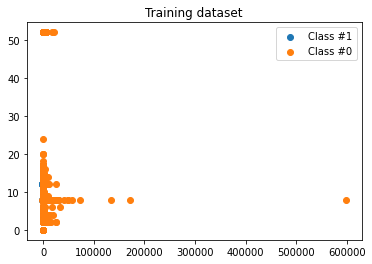

In [9]:
#Add anomaly detection code  (Question #E201)
#----------------------------------

rng = np.random.RandomState(42)

def plot_scatter(X, y, title):
    """Function to plot some data as a scatter plot."""
    plt.figure()
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1")
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0")
    plt.legend()
    plt.title(title)

plot_scatter(X_train,y_train, "Training dataset")


Num of outliers = 791


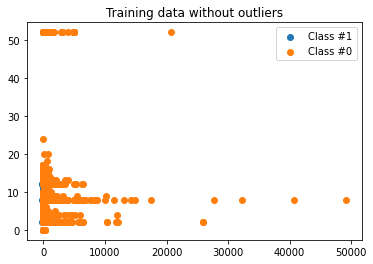

In [10]:
def outlier_rejection(X, y):
    model_isolationf = IsolationForest(max_samples=100, contamination=0.05, random_state=rng)
    model_isolationf.fit(X)
    y_pred = model_isolationf.predict(X)
    return X[y_pred == 1], y[y_pred == 1],y_pred == -1

X3_inliers, y3_inliers, outliers_3 = outlier_rejection(X_train,y_train)
plot_scatter(X3_inliers, y3_inliers, "Training data without outliers")
print(f"Num of outliers = {np.sum(outliers_3)}")

In [11]:
# Add codes for feature selection and classification pipeline with grid search (Question #E202)
# ----------------------------------
pca_components = 20
pipe = Pipeline([
    ('scale', StandardScaler()),                  
    ('PCA', PCA(n_components= pca_components)), 
    ('SVC', SVC(kernel='rbf'))                  
])

param_grid = {'SVC__C': [40000, 50000, 60000], 
              'SVC__gamma': [0.05, 0.1, 0.2], 
              'PCA__n_components': [20],
              'SVC__kernel': ['rbf']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
model_grid_svc = GridSearchCV(pipe, param_grid = param_grid, cv=cv, n_jobs=5)
model_grid_svc.fit(X3_inliers, y3_inliers)
print("Parameters of the best model are:",model_grid_svc.best_estimator_)
print("Score of the best model:", model_grid_svc.best_score_)

Parameters of the best model are: Pipeline(steps=[('scale', StandardScaler()), ('PCA', PCA(n_components=20)),
                ('SVC', SVC(C=50000, gamma=0.1))])
Score of the best model: 0.8550501872738889


In [12]:
# Given an unbiased evaluation  (Question #E203)
# ----------------------------------
#Displaying results for training dataset
predicted_y = model_grid_svc.predict(X_train)
#classification report
print(classification_report(y_train, predicted_y))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      7889
           1       0.89      0.86      0.88      7921

    accuracy                           0.88     15810
   macro avg       0.88      0.88      0.88     15810
weighted avg       0.88      0.88      0.88     15810



In [13]:
#confusion matrix of trained dataset
pd.DataFrame(confusion_matrix(y_train, predicted_y))

,0,1
0,7056,833
1,1071,6850


#### <center>Record the optimal hyperparameters and performance resulting from this pipeline.</center>

## <span style="background: yellow;">Commit your code!</span> 

### Your 2nd pipeline
  * Anomaly detection
  * Dimensionality reduction
  * Model training/validation

# Using OneClassSVM for anamoly detection, Logistic Regression as classification method and Factor Analysis for feature reduction with different parameters.

In [14]:
# Add anomaly detection code  (Question #E205)

#Using the OneClassSVM for Anamoly detection for various nu values
# ----------------------------------
def outlier_rejection2(X, y, nu):
    model_oc_svm = OneClassSVM(kernel='rbf',nu=nu)
    model_oc_svm.fit(X)
    y_pred = model_oc_svm.predict(X)
    return X[y_pred == 1], y[y_pred == 1],y_pred == -1

Num of outliers = 798


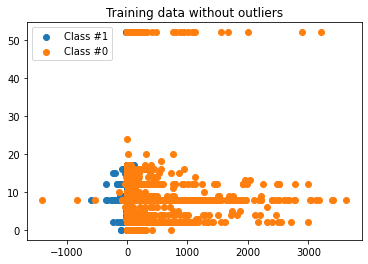

In [15]:
X_inliers_svm2, y_inliers_svm2, outliers_svm2 = outlier_rejection2(X_train,y_train,nu=0.05)
plot_scatter(X_inliers_svm2, y_inliers_svm2, "Training data without outliers")
print(f"Num of outliers = {np.sum(outliers_svm2)}")

In [16]:
# Add codes for feature selection and classification pipeline with grid search  (Question #E206)
# ----------------------------------
#Using Factor Analysis for feature selection and logistic regressor classifier for classification

pipe2 = Pipeline([
    ('scale', StandardScaler()),          
    ('FA', FactorAnalysis()),             
    ('LR', LogisticRegression(max_iter=100))        
])

In [17]:
param_gridLR = { 
              'FA__n_components':[11, 12, 13],
              'LR__C':[40, 50, 70],
              'LR__penalty': ['l1','l2'],
              'LR__solver': ['liblinear','lbfgs']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
model_gridLR = GridSearchCV(pipe2, param_grid = param_gridLR, cv=cv, n_jobs=5)

In [18]:
model_gridLR.fit(X_inliers_svm2, y_inliers_svm2)
print("Parameters of the best model are:",model_gridLR.best_estimator_)
print("Score of the best model:", model_gridLR.best_score_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.76412191        nan 0.76398867 0.76398867 0.76412191        nan
 0.76398867 0.76398867 0.76412191        nan 0.76398867 0.76412191
 0.7559922         nan 0.7559922  0.75592558 0.7559922         nan
 0.75592558 0.75592558 0.7559922         nan 0.75592558 0.7559922
 0.76938462        nan 0.76931802 0.76931802 0.76938462        nan
 0.76931802 0.76931802 0.76938462        nan 0.76938462 0.76938462]
  category=UserWarning


Parameters of the best model are: Pipeline(steps=[('scale', StandardScaler()),
                ('FA', FactorAnalysis(n_components=13)),
                ('LR',
                 LogisticRegression(C=40, penalty='l1', solver='liblinear'))])
Score of the best model: 0.7693846238150035


In [19]:
# Given an unbiased evaluation  (Question #E207)
# ----------------------------------
#Displaying results for training dataset
predicted_yLR = model_gridLR.predict(X_train) #logistic regression 2nd pipeline 
#classification report
print(classification_report(y_train, predicted_yLR))

              precision    recall  f1-score   support

           0       0.89      0.66      0.75      7889
           1       0.73      0.92      0.81      7921

    accuracy                           0.79     15810
   macro avg       0.81      0.79      0.78     15810
weighted avg       0.81      0.79      0.78     15810



In [20]:
#confusion matrix
pd.DataFrame(confusion_matrix(y_train, predicted_yLR))

,0,1
0,5169,2720
1,669,7252


#### <center>Record the optimal hyperparameters and performance resulting from this pipeline.</center>

## <span style="background: yellow;">Commit your code!</span> 

### Your 3rd pipeline
  * Anomaly detection
  * Dimensionality reduction
  * Model training/validation

# Using EllipticEnvelope for anamoly detection, Random Forest as classification method and RFE for feature reduction with different parameters.

Num of outliers = 791


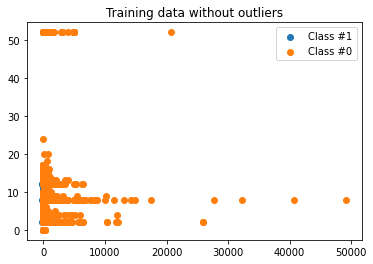

In [21]:
# Add anomaly detection code  (Question #E209)
# ----------------------------------
#Using EllipticEnvelope for anamoly detection

def outlier_rejection3(X, y):
    model_ee = EllipticEnvelope(support_fraction=0.1, contamination=0.05)
    model_ee.fit(X)
    y_pred = model_ee.predict(X)
    return X[y_pred == 1], y[y_pred == 1],y_pred == -1

X_ee5, y_ee5, outliers_ee5 = outlier_rejection3(X_train,y_train)
plot_scatter(X3_inliers, y3_inliers, "Training data without outliers")
print(f"Num of outliers = {np.sum(outliers_ee5)}")

In [22]:
estimator = LogisticRegression()
pipe3 = Pipeline([('scale', StandardScaler()),                 
                ('RFE', RFE(estimator)),
                ('RandomForest',RandomForestClassifier())
                ])

param_grid_RF2 = {
              'RFE__n_features_to_select':[5, 10, 20],
              'RandomForest__n_estimators':[20, 25, 30],
              'RandomForest__criterion': ['entropy','gini'],
              'RandomForest__min_samples_split': [6, 8, 10],
              'RandomForest__min_samples_leaf': [2,3,4] 
             }
     
cv3 = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
model_grid_RF2 = GridSearchCV(pipe3, param_grid = param_grid_RF2, cv=cv3, n_jobs=5)
modelRF_ee6= model_grid_RF2.fit(X_ee5, y_ee5)
print("Parameters of the best model are:",modelRF_ee6.best_estimator_)
print("Score of the best model:", modelRF_ee6.best_score_)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Parameters of the best model are: Pipeline(steps=[('scale', StandardScaler()),
                ('RFE',
                 RFE(estimator=LogisticRegression(), n_features_to_select=20)),
                ('RandomForest',
                 RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                                        min_samples_split=6,
                                        n_estimators=30))])
Score of the best model: 0.8967971442671843


In [23]:
predicted_y_train_rf_ee6 = modelRF_ee6.predict(X_train)
print(classification_report(y_train, predicted_y_train_rf_ee6))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      7889
           1       0.95      0.97      0.96      7921

    accuracy                           0.96     15810
   macro avg       0.96      0.96      0.96     15810
weighted avg       0.96      0.96      0.96     15810



In [24]:
pd.DataFrame(confusion_matrix(y_train, predicted_y_train_rf_ee6))

,0,1
0,7490,399
1,268,7653


#### <center>Record the optimal hyperparameters and performance resulting from this pipeline.</center>

## Compare these three pipelines and discuss your findings

# Test data prediction results with and without outliers

# First Pipeline

In [25]:
#Using first pipeline model to predict test data with outliers
pipe1_predicted_y = model_grid_svc.predict(X_test)
#classification report
print(classification_report(y_test, pipe1_predicted_y))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      3404
           1       0.85      0.83      0.84      3372

    accuracy                           0.84      6776
   macro avg       0.84      0.84      0.84      6776
weighted avg       0.84      0.84      0.84      6776



In [26]:
#The confusion matrix for prediction using first pipeline and with outliers
pd.DataFrame(confusion_matrix(y_test, pipe1_predicted_y))

,0,1
0,2910,494
1,590,2782


In [27]:
#Removing outliers from test data to be used in the first pipeline
X_test_inliers1, y_test_inliers1, outliers_test1 = outlier_rejection(X_test,y_test)
print(f"Num of outliers = {np.sum(outliers_test1)}")

Num of outliers = 339


In [28]:
#Using first pipeline model to predict test data with inliers
pipe1_predicted_y_in = model_grid_svc.predict(X_test_inliers1)
#classification report
print(classification_report(y_test_inliers1, pipe1_predicted_y_in))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3227
           1       0.85      0.85      0.85      3210

    accuracy                           0.85      6437
   macro avg       0.85      0.85      0.85      6437
weighted avg       0.85      0.85      0.85      6437



In [29]:
#The confusion matrix for prediction using first pipeline and with inliers
pd.DataFrame(confusion_matrix(y_test_inliers1, pipe1_predicted_y_in))

,0,1
0,2737,490
1,480,2730


# Second Pipeline

In [30]:
#Using second pipeline model to predict test data with outliers
pipe2_predicted_y = model_gridLR.predict(X_test)
#classification report
print(classification_report(y_test, pipe2_predicted_y))

              precision    recall  f1-score   support

           0       0.88      0.64      0.74      3404
           1       0.71      0.91      0.80      3372

    accuracy                           0.77      6776
   macro avg       0.80      0.77      0.77      6776
weighted avg       0.80      0.77      0.77      6776



In [31]:
#The confusion matrix for prediction using second pipeline and with outliers
pd.DataFrame(confusion_matrix(y_test, pipe2_predicted_y))

,0,1
0,2171,1233
1,304,3068


In [32]:
#Removing outliers from test data to be used in the second pipeline
X_test_inliers2, y_test_inliers2, outliers_test2 = outlier_rejection2(X_test,y_test,0.05)
print(f"Num of outliers = {np.sum(outliers_test2)}")

Num of outliers = 332


In [33]:
#Using second pipeline model to predict test data with inliers
pipe2_predicted_y_in = model_gridLR.predict(X_test_inliers2)
#classification report
print(classification_report(y_test_inliers2, pipe2_predicted_y_in))

              precision    recall  f1-score   support

           0       0.88      0.64      0.74      3164
           1       0.73      0.91      0.81      3280

    accuracy                           0.78      6444
   macro avg       0.80      0.78      0.78      6444
weighted avg       0.80      0.78      0.78      6444



In [34]:
#The confusion matrix for prediction using second pipeline and with inliers
pd.DataFrame(confusion_matrix(y_test_inliers2, pipe2_predicted_y_in))

,0,1
0,2032,1132
1,284,2996


# Third Pipeline

In [35]:
#Using third pipeline model to predict test data with outliers
pipe3_predicted_y = modelRF_ee6.predict(X_test)
#classification report
print(classification_report(y_test, pipe3_predicted_y))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      3404
           1       0.88      0.92      0.90      3372

    accuracy                           0.90      6776
   macro avg       0.90      0.90      0.90      6776
weighted avg       0.90      0.90      0.90      6776



In [36]:
#The confusion matrix for prediction using third pipeline and with outliers
pd.DataFrame(confusion_matrix(y_test, pipe3_predicted_y))

,0,1
0,2992,412
1,283,3089


In [37]:
#Removing outliers from test data to be used in the third pipeline
X_test_inliers3, y_test_inliers3, outliers_test3 = outlier_rejection3(X_test,y_test)
print(f"Num of outliers = {np.sum(outliers_test3)}")

Num of outliers = 359


In [38]:
#Using third pipeline model to predict test data with inliers
pipe3_predicted_y_in = modelRF_ee6.predict(X_test_inliers3)
#classification report
print(classification_report(y_test_inliers3, pipe3_predicted_y_in))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      3196
           1       0.88      0.92      0.90      3221

    accuracy                           0.90      6417
   macro avg       0.90      0.90      0.90      6417
weighted avg       0.90      0.90      0.90      6417



In [39]:
#The confusion matrix for prediction using third pipeline and with inliers
pd.DataFrame(confusion_matrix(y_test_inliers3, pipe3_predicted_y_in))

,0,1
0,2804,392
1,255,2966


# Comparision of all models : 

## <span style="background: yellow;">Commit your code!</span> 

### Pickle the required pipeline/models for Part III.

In [40]:
import joblib
# for dumping 
joblib.dump([X3_inliers, y3_inliers, model_grid_svc], 'pipeline1_model_svc.pkl')

['pipeline1_model_svc.pkl']

In [41]:
model_isolationf = IsolationForest(max_samples=100, contamination=0.05)
joblib.dump([X3_inliers, y3_inliers, model_isolationf], 'model1_outlier.pkl')

['model1_outlier.pkl']

In [42]:
model_oc_svm = OneClassSVM(kernel='rbf',nu=0.1)
joblib.dump([X_inliers_svm2, y_inliers_svm2, model_oc_svm],'model2_outlier.pkl')
joblib.dump([X_inliers_svm2, y_inliers_svm2, model_gridLR], 'pipeline2_model_LR.pkl')


['pipeline2_model_LR.pkl']

In [43]:
model_ee = EllipticEnvelope(support_fraction=0.1, contamination=0.05)
joblib.dump([X_ee5, y_ee5, model_ee],'model3_outlier.pkl')
joblib.dump([X_ee5, y_ee5, modelRF_ee6], 'pipeline3_model_RF.pkl')

['pipeline3_model_RF.pkl']

You should have made a few commits so far of this project.  
**Definitely make a commit of the notebook now!**  
Comment should be: `Final Project, Checkpoint - Pipelines done`


# Save your notebook!
## Then `File > Close and Halt`